In [1]:
import roboticstoolbox as rbt
from spatialmath import *
import numpy as np

In [2]:
pi = np.pi
l1 = 3
l2 = 3

In [3]:
# 3R-R-3R
human_arm = rbt.DHRobot([
        rbt.RevoluteMDH(), #joint 1
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 2
        rbt.RevoluteMDH(alpha = -pi/2), #joint 3
        rbt.RevoluteMDH(a = l1, alpha = pi/2, offset = -pi/2), #joint 4
        rbt.RevoluteMDH(alpha = -pi/2, d = l2), #joint 5
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 6
        rbt.RevoluteMDH(alpha = -pi/2), #joint 7
    ],
    name = "Human Arm"
)
human_arm

DHRobot: Human Arm, 7 joints (RRRRRRR), dynamics, modified DH parameters
┌──────┬────────┬───────────┬─────┐
│ aⱼ₋₁ │  ⍺ⱼ₋₁  │    θⱼ     │ dⱼ  │
├──────┼────────┼───────────┼─────┤
│  0.0 │   0.0° │        q1 │ 0.0 │
│  0.0 │  90.0° │  q2 + 90° │ 0.0 │
│  0.0 │ -90.0° │        q3 │ 0.0 │
│    3 │  90.0° │  q4 - 90° │ 0.0 │
│  0.0 │ -90.0° │        q5 │   3 │
│  0.0 │  90.0° │  q6 + 90° │ 0.0 │
│  0.0 │ -90.0° │        q7 │ 0.0 │
└──────┴────────┴───────────┴─────┘

┌──┬──┐
└──┴──┘

# MoveJ mode

## Forward Kinematics

In [4]:
q = [0,0,0,0,0,0,0]

In [5]:
T_0e = human_arm.fkine(q)
T_0e

   0         0        -1         0         
   0         1         0         0         
   1         0         0         6         
   0         0         0         1         


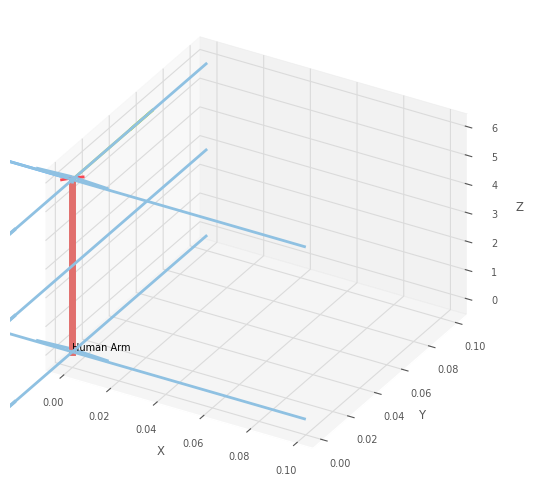

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [6]:
human_arm.plot(q)

## Invert Kinematics

In [7]:
T_goal = SE3(5,1,3) @ SE3.Rx(pi/2)
T_goal

   1         0         0         5         
   0         0        -1         1         
   0         1         0         3         
   0         0         0         1         


In [8]:
q_sol = human_arm.ikine_LM(T_goal)

In [9]:
q_sol

IKSolution(q=array([ 1.87057416,  2.98382289, -2.08732187, -0.33489619, -0.01531616,
        3.13917463,  2.60376302]), success=True, iterations=7, searches=1, residual=2.986375098425564e-09, reason='Success')

In [10]:
q_sol.q

array([ 1.87057416,  2.98382289, -2.08732187, -0.33489619, -0.01531616,
        3.13917463,  2.60376302])

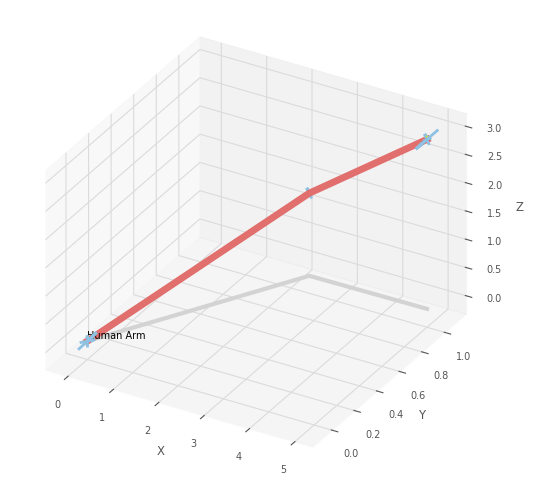

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [11]:
human_arm.plot(q_sol.q)

# MoveL mode

## Velocity calculation

In [12]:
current_q = [0,0,0.5,0.25,0,0,0]
current_q

[0, 0, 0.5, 0.25, 0, 0, 0]

### Forward Kinematics

In [20]:
current_pos = human_arm.fkine(current_q)
current_pos

  -0.2474    0        -0.9689   -0.7422    
   0.4645    0.8776   -0.1186    2.832     
   0.8503   -0.4794   -0.2171    5.184     
   0         0         0         1         


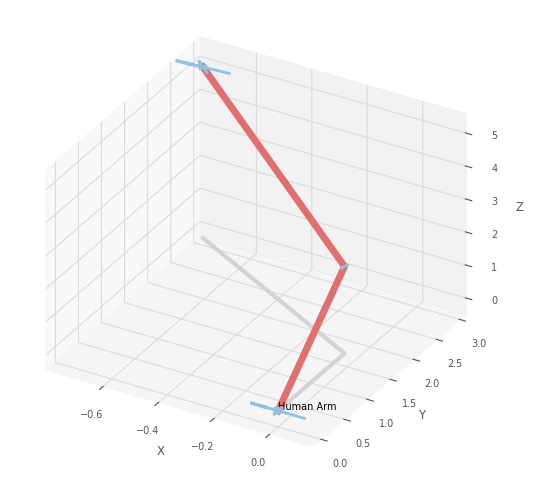

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [21]:
human_arm.plot(current_q)

### Target direction 

In [19]:
target = [5,1,3,0,0,0]
target

[5, 1, 3, 0, 0, 0]

In [49]:
current_pos.rpy()[0]

-1.9960343072911189

In [50]:
target_direction = [
    target[0] - current_pos.x,
    target[1] - current_pos.y,
    target[2] - current_pos.z,
    target[3] - current_pos.rpy()[0], # roll
    target[4] - current_pos.rpy()[1], # pitch
    target[5] - current_pos.rpy()[2] # yall
]
target_direction

[5.742211877763569,
 -1.8318406947293946,
 -2.183649621547816,
 1.9960343072911189,
 1.0165562766407954,
 -2.060182348925404]

In [51]:
linear_size = np.sqrt(target_direction[0]**2 + target_direction[1]**2 + target_direction[2]**2)
linear_size

6.410691323849683

In [52]:
angular_size = np.sqrt(target_direction[3]**2 + target_direction[4]**2 + target_direction[5]**2)
angular_size

3.043335494204464

In [53]:
unit_target_direction =[
    target_direction[0] / linear_size,
    target_direction[1] / linear_size,
    target_direction[2] / linear_size,
    target_direction[3] / angular_size,
    target_direction[4] / angular_size,
    target_direction[5] / angular_size,
]
unit_target_direction

[0.8957242811552677,
 -0.2857477613864204,
 -0.34062623065690095,
 0.655870610089568,
 0.3340270169281898,
 -0.6769488125277956]

In [54]:
vel = [
    unit_target_direction[0] * 0.5,
    unit_target_direction[1] * 0.5,
    unit_target_direction[2] * 0.5,
    unit_target_direction[3] * 0.5,
    unit_target_direction[4] * 0.5,
    unit_target_direction[5] * 0.5,
]

## Jacobian

In [55]:
J = human_arm.jacob0(current_q)
J

array([[-2.83184069e+00, -5.18364962e+00, -4.90807228e-16,
        -2.90673727e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-7.42211878e-01,  3.54551686e-17,  5.18364962e+00,
        -3.55835329e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.53327403e-16, -7.42211878e-01, -2.83184069e+00,
        -6.51352201e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.42452169e-20,  4.39785294e-19, -1.00000000e+00,
         2.18604414e-17, -2.47403959e-01,  2.18604414e-17,
        -9.68912422e-01],
       [ 1.58536786e-16, -1.00000000e+00, -4.11935781e-17,
        -8.77582562e-01,  4.64521360e-01, -8.77582562e-01,
        -1.18611776e-01],
       [ 1.00000000e+00, -1.03025634e-16,  5.54669060e-17,
         4.79425539e-01,  8.50300645e-01,  4.79425539e-01,
        -2.17117400e-01]])

In [56]:
Jt = J.transpose()
Jt

array([[-2.83184069e+00, -7.42211878e-01, -2.53327403e-16,
         4.42452169e-20,  1.58536786e-16,  1.00000000e+00],
       [-5.18364962e+00,  3.54551686e-17, -7.42211878e-01,
         4.39785294e-19, -1.00000000e+00, -1.03025634e-16],
       [-4.90807228e-16,  5.18364962e+00, -2.83184069e+00,
        -1.00000000e+00, -4.11935781e-17,  5.54669060e-17],
       [-2.90673727e+00, -3.55835329e-01, -6.51352201e-01,
         2.18604414e-17, -8.77582562e-01,  4.79425539e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.47403959e-01,  4.64521360e-01,  8.50300645e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.18604414e-17, -8.77582562e-01,  4.79425539e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.68912422e-01, -1.18611776e-01, -2.17117400e-01]])

In [57]:
Jit = np.linalg.inv(np.dot(J,J.transpose()))
Jit

array([[ 2.22222222e-01, -6.32554441e-01, -1.15788314e+00,
        -1.47777495e-16,  2.49603940e-16, -2.83786497e-16],
       [-6.32554441e-01,  2.46988563e+00,  4.41779590e+00,
         1.46263760e-01, -5.58055834e-01,  3.25809814e-01],
       [-1.15788314e+00,  4.41779590e+00,  8.14315388e+00,
        -7.99042564e-02, -1.04245688e+00,  5.58055834e-01],
       [ 3.79133489e-17,  1.46263760e-01, -7.99042564e-02,
         9.92228105e-01,  2.96529441e-02,  5.42793501e-02],
       [ 1.46918216e-16, -5.58055834e-01, -1.04245688e+00,
         2.96529441e-02,  8.86861937e-01, -2.07097834e-01],
       [-1.68474960e-16,  3.25809814e-01,  5.58055834e-01,
         5.42793501e-02, -2.07097834e-01,  6.20909957e-01]])

In [58]:
J_new = np.dot(Jt,Jit)
J_new

array([[-1.59808513e-01,  2.83924769e-01,  5.58055834e-01,
        -5.42793501e-02,  2.07097834e-01,  3.79090043e-01],
       [-2.92527521e-01,  5.58055834e-01,  1.00057183e+00,
         2.96529441e-02, -1.13138063e-01, -2.07097834e-01],
       [-2.28460556e-16,  1.46263760e-01, -7.99042564e-02,
        -7.77189457e-03,  2.96529441e-02,  5.42793501e-02],
       [ 3.33333333e-01, -1.27180247e+00, -2.32801880e+00,
        -2.84308836e-16,  3.75582931e-16, -4.51151408e-16],
       [-8.43876303e-17, -1.83787928e-02,  1.00403803e-02,
        -1.85552969e-01,  2.28534635e-01,  4.18329843e-01],
       [-2.09704062e-16,  6.45941614e-01,  1.18238819e+00,
         1.80597055e-16, -8.77582562e-01,  4.79425539e-01],
       [-1.75821000e-17, -1.46263760e-01,  7.99042564e-02,
        -9.76684316e-01, -8.89588323e-02, -1.62838050e-01]])

## Calculate q_dot

In [60]:
q_dot = np.dot(J_new,vel)
q_dot

array([-0.3187061 , -0.32022813, -0.02325694,  0.72748687, -0.1633591 ,
       -0.60250582, -0.27274156])